In [95]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import optuna

In [74]:
# dataset_selected = 'selected_files'
dataset_selected = 'audio_and_txt_files'

# Dataframe diagnosis sound extracts

In [75]:
df_demographic = pd.read_csv("data/demographic_info.txt", sep=' ', header=None, na_values='NA')
df_demographic.columns = ["patient_number","age","sex", "adult_bmi","child_weight","child_height"]

df_patient_diagnosis = pd.read_csv("data/patient_diagnosis.csv")
df_patient_diagnosis.columns = ["patient_number","diagnosis"]

# merge the two dataframes on the patient_number column
merged_df = pd.merge(df_demographic, df_patient_diagnosis, on='patient_number')

# extract filenames from dataset_selected directory
selected_filenames = os.listdir("data/" + dataset_selected)
patients_numbers = [int(filename.split('_')[0].split('.')[0]) for filename in selected_filenames]

# we keep only the patients that are in the selected files
merged_df = merged_df[merged_df['patient_number'].isin(patients_numbers)]
merged_df.sort_values(by='patient_number', inplace=True)
print(merged_df)
    

     patient_number    age  sex  adult_bmi  child_weight  child_height  \
0               102   0.75    F        NaN           9.8          73.0   
1               103  70.00    F      33.00           NaN           NaN   
2               104  70.00    F      28.47           NaN           NaN   
3               105   7.00    F        NaN          32.0         135.0   
4               106  73.00    F      21.00           NaN           NaN   
..              ...    ...  ...        ...           ...           ...   
120             222  60.00    M        NaN           NaN           NaN   
121             223    NaN  NaN        NaN           NaN           NaN   
122             224  10.00    F        NaN          32.3         143.0   
123             225   0.83    M        NaN           7.8          74.0   
124             226   4.00    M        NaN          16.7         103.0   

     diagnosis  
0      Healthy  
1       Asthma  
2         COPD  
3         URTI  
4         COPD  
..       

# Several diagnosis plots

In [76]:
def generate_plot(merged_df, class_name):
    patient = merged_df[merged_df['diagnosis'] == class_name].iloc[0]
    filenames = [filename for filename in selected_filenames if filename.startswith(str(patient['patient_number']))]
    wav_filename = [filename for filename in filenames if filename.endswith("wav")][0]
    txt_filename = [filename for filename in filenames if filename.endswith("txt")][0]
    # Load txt file
    df_txt_file = pd.read_csv(Path.cwd() / "data" / dataset_selected / txt_filename, sep='\t', header=None, na_values='NA')
    df_txt_file.columns = ["start", "end", "crackles", "wheezes"]
    # Load wav file
    y, sr = librosa.load(Path.cwd() / "data" / dataset_selected / wav_filename)
    # Plot
    plt.figure(figsize=(12, 8))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform of the first "+ class_name +" patient")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    # Annotate the plot
    for index, row in df_txt_file.iterrows():
        time = row['start']
        if row['crackles'] == 1:
            plt.annotate('crackle', 
                        xy=(time, 0), 
                        xytext=(time + 0.5, 0.3),
                        arrowprops=dict(facecolor='black', arrowstyle='->'))
        if row["wheezes"] == 1:
            plt.annotate('wheeze', 
                        xy=(time, 0), 
                        xytext=(time + 0.5, 0.3),
                        arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()
    return wav_filename


In [77]:
def generate_spectrogram(wav_filename, class_name):
    y, sr = librosa.load(Path.cwd() / "data" / dataset_selected / wav_filename)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram of the first '+ class_name +' patient')
    plt.show()
    return y, sr


## Healthy

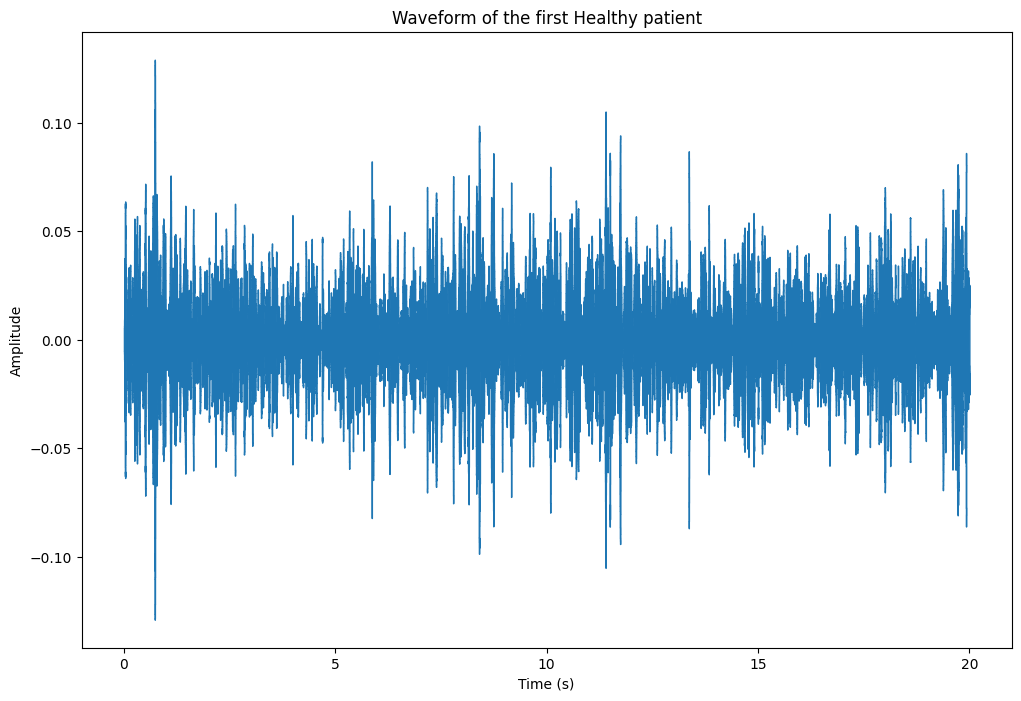

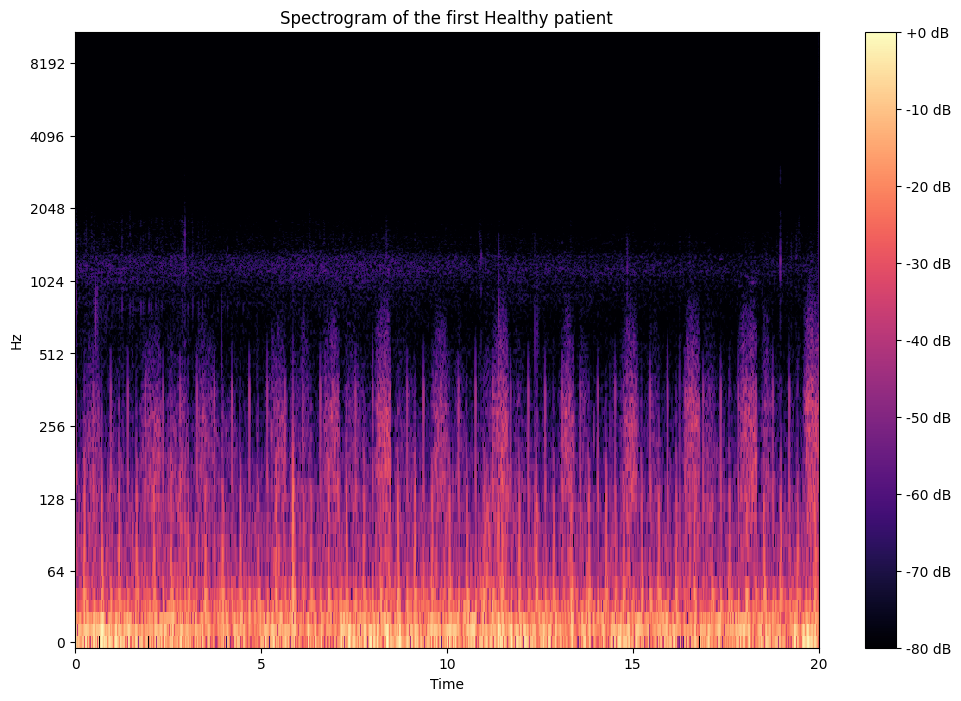

(array([ 0.00284162,  0.00422829,  0.00364514, ..., -0.01374734,
        -0.01390195, -0.01605711], dtype=float32),
 22050)

In [78]:
wav_filename = generate_plot(merged_df, "Healthy")
Audio(Path.cwd() / "data" / dataset_selected / wav_filename)
generate_spectrogram(wav_filename, "Healthy")

## Asthma

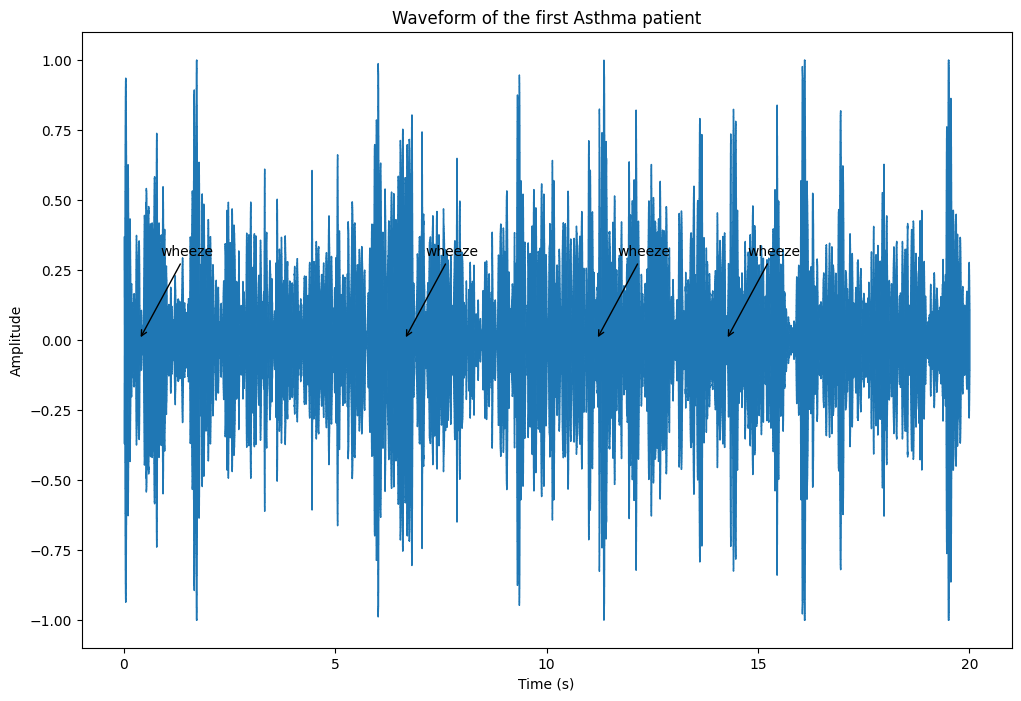

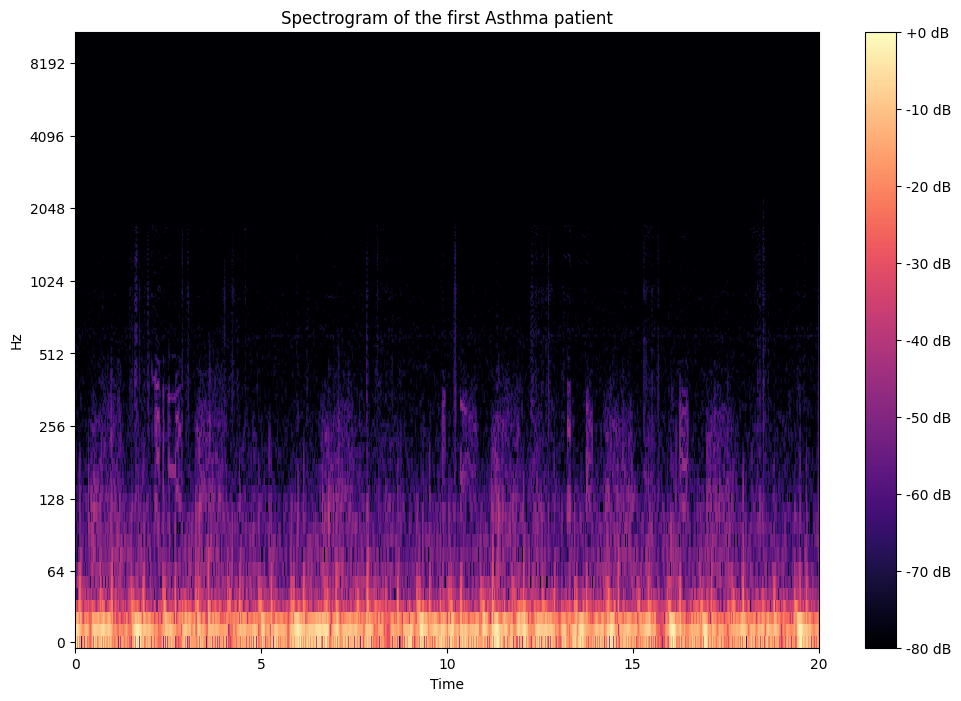

(array([-0.2553652 , -0.36991683, -0.32370543, ..., -0.05160575,
        -0.04817004, -0.05143753], dtype=float32),
 22050)

In [79]:
wav_filename = generate_plot(merged_df, "Asthma")
Audio(Path.cwd() / "data" / "selected_files" / wav_filename)
generate_spectrogram(wav_filename, "Asthma")

## COPD  

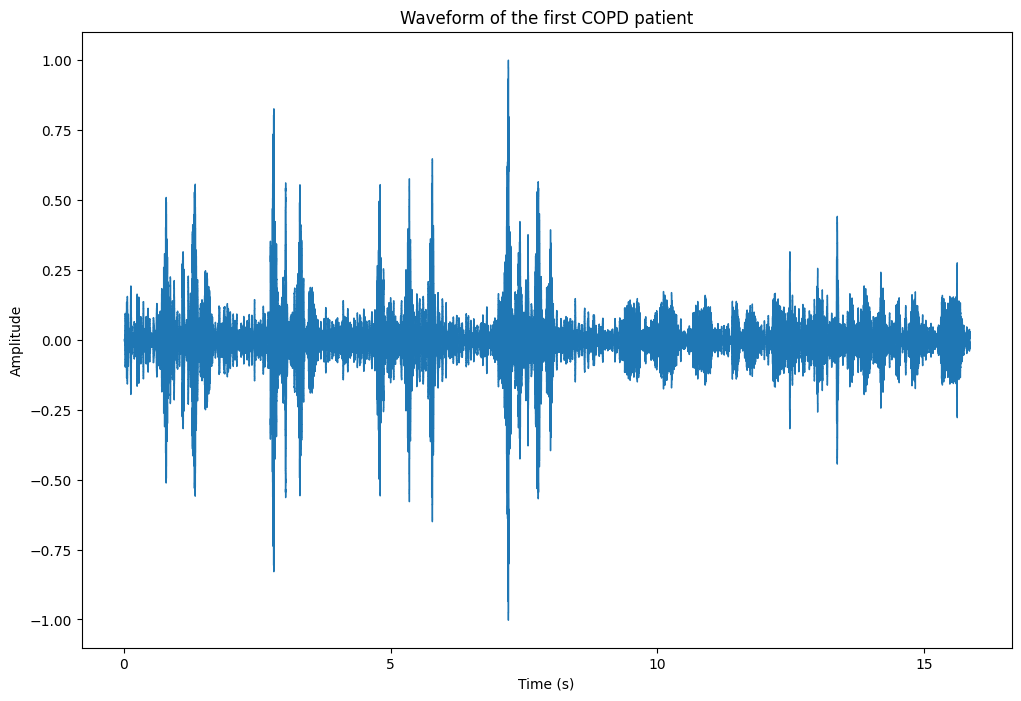

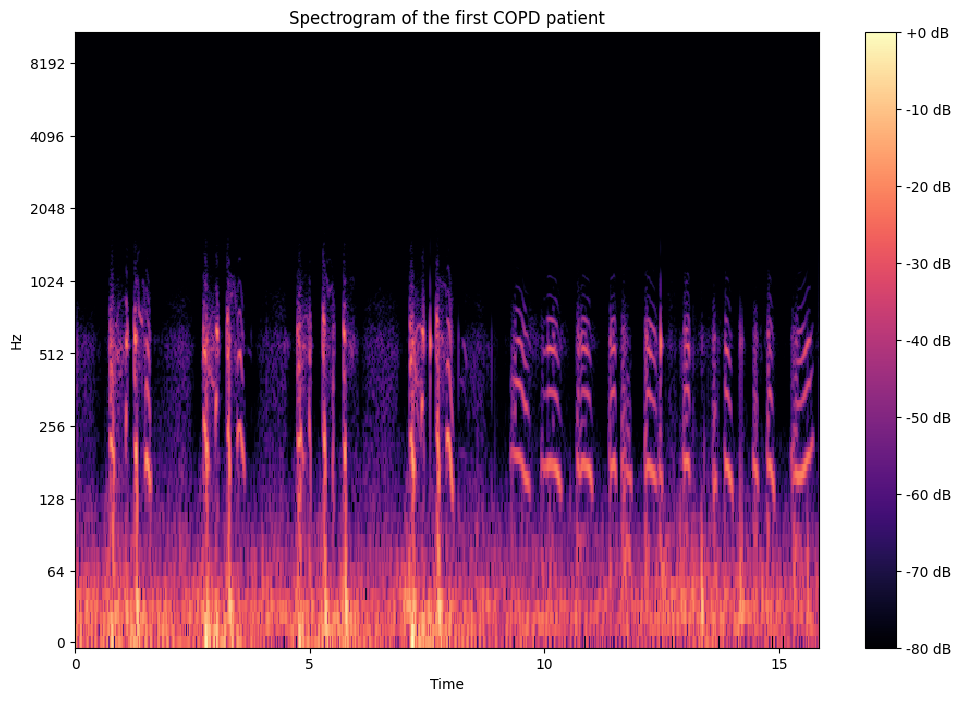

(array([ 2.8137118e-05,  6.2920153e-06, -3.5382807e-05, ...,
        -1.4128329e-02, -8.6970516e-03, -3.8011954e-03], dtype=float32),
 22050)

In [80]:
wav_filename = generate_plot(merged_df, "COPD")
Audio(Path.cwd() / "data" / dataset_selected / wav_filename)
generate_spectrogram(wav_filename, "COPD")

## URTI  

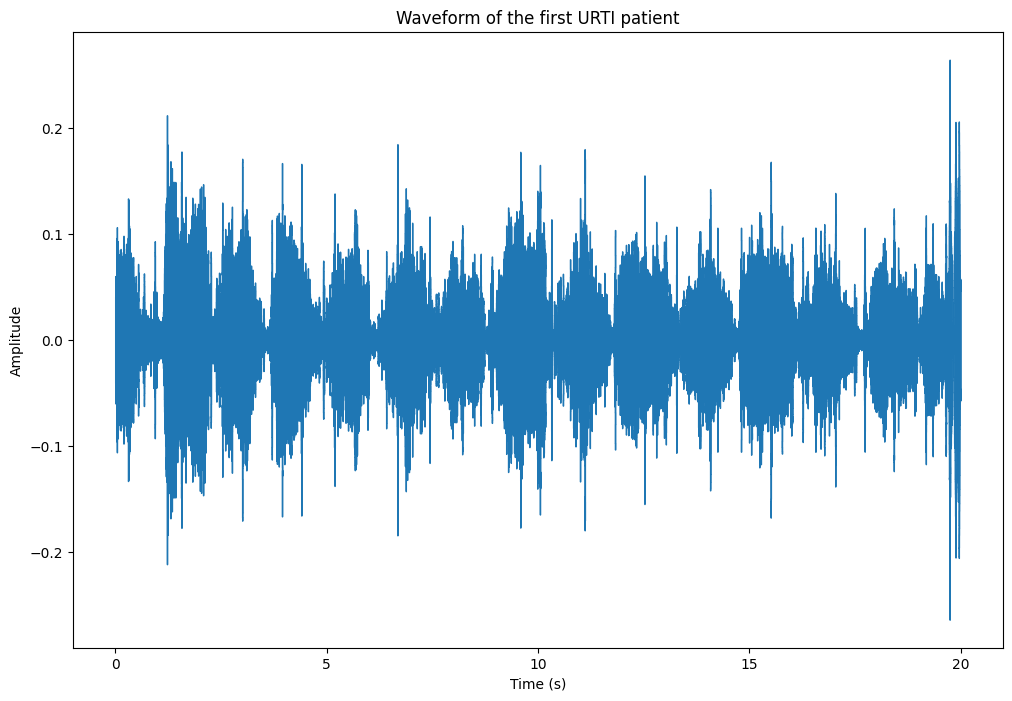

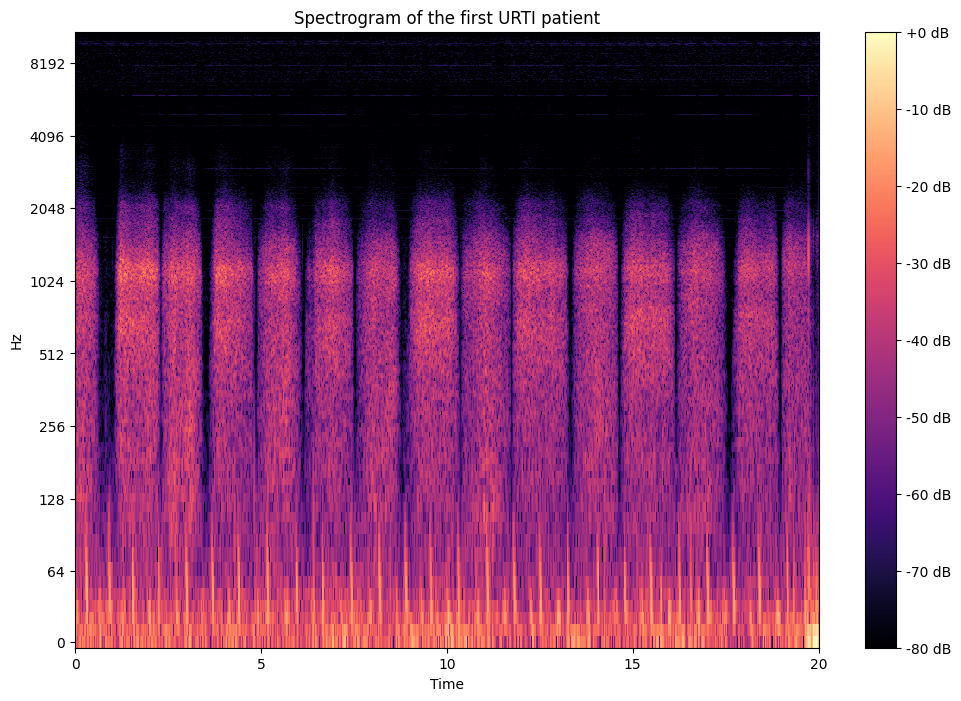

(array([0.00082267, 0.00168314, 0.00343998, ..., 0.03299017, 0.03149725,
        0.03432505], dtype=float32),
 22050)

In [81]:
wav_filename = generate_plot(merged_df, "URTI")
Audio(Path.cwd() / "data" / "selected_files" / wav_filename)
generate_spectrogram(wav_filename, "URTI")

## LRTI  

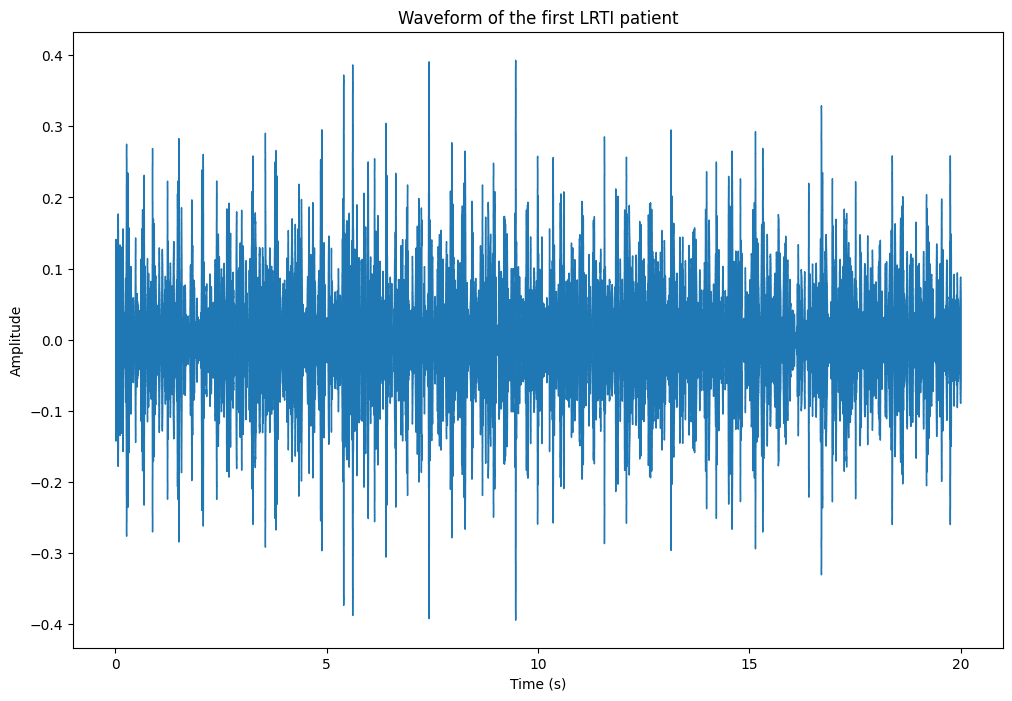

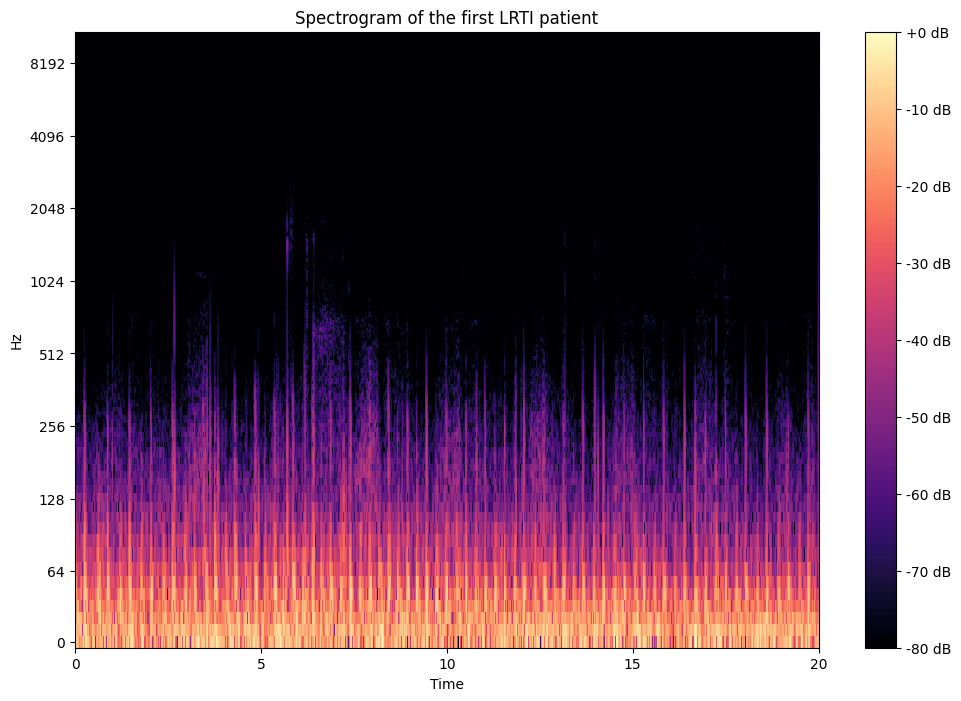

(array([-0.00952007, -0.01513208, -0.01496341, ...,  0.03132168,
         0.02991456,  0.03197349], dtype=float32),
 22050)

In [82]:
wav_filename = generate_plot(merged_df, "LRTI")
Audio(Path.cwd() / "data" / dataset_selected / wav_filename)
generate_spectrogram(wav_filename, "LRTI")

## Bronchiectasis

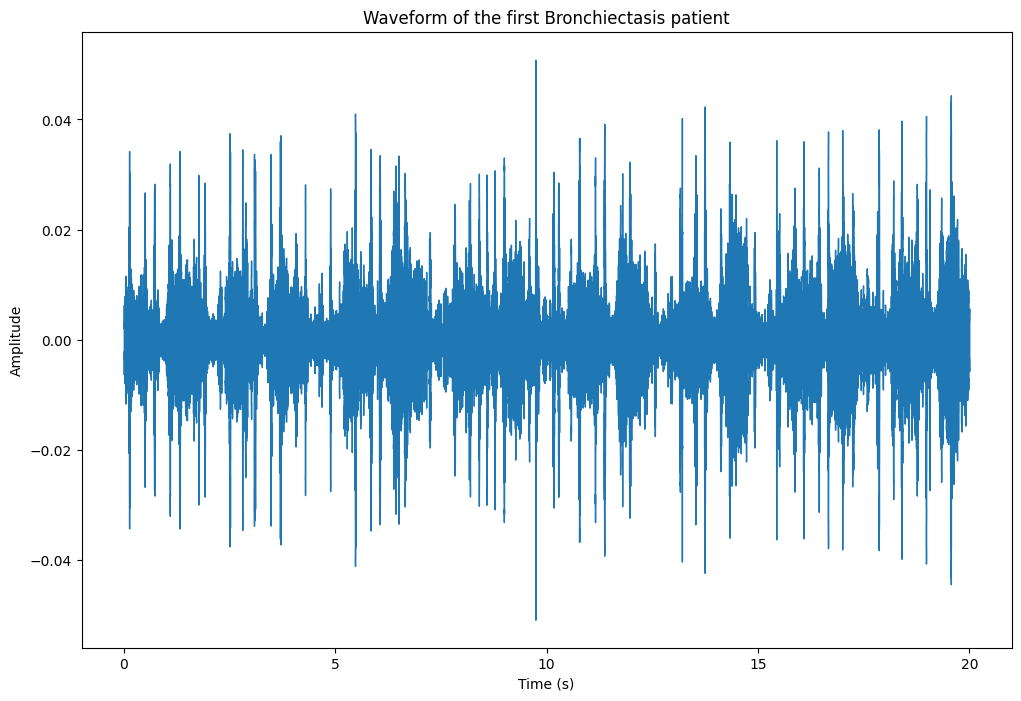

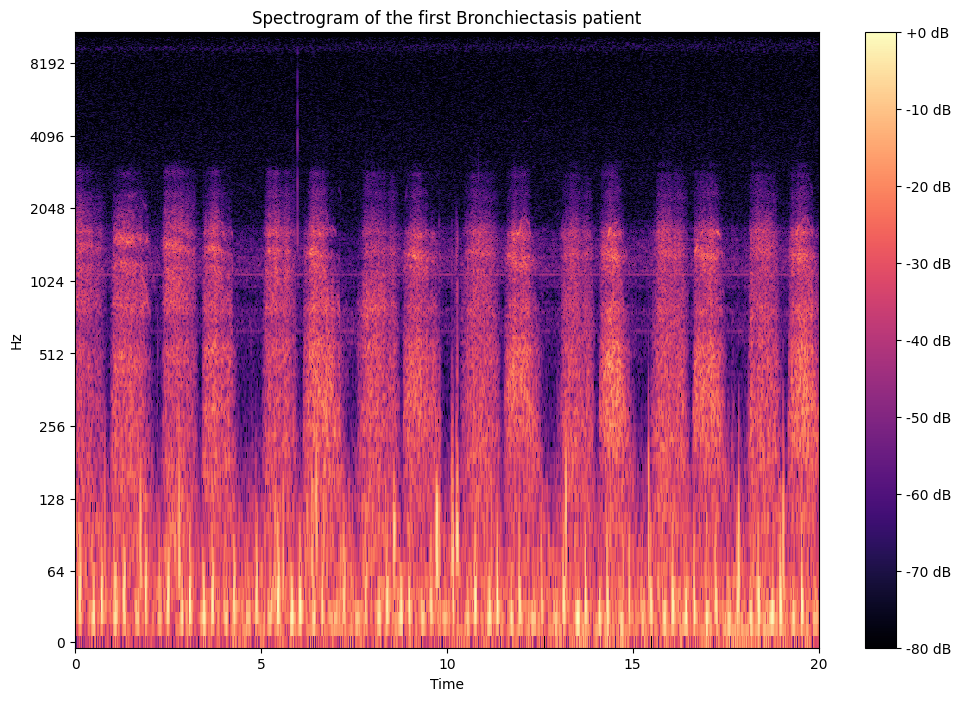

(array([-0.00200442, -0.00318893, -0.00332277, ..., -0.00063941,
        -0.00038693, -0.00015917], dtype=float32),
 22050)

In [83]:
wav_filename = generate_plot(merged_df, "Bronchiectasis")
Audio(Path.cwd() / "data" / "selected_files" / wav_filename)
generate_spectrogram(wav_filename, "Bronchiectasis")

## Bronchiolitis  

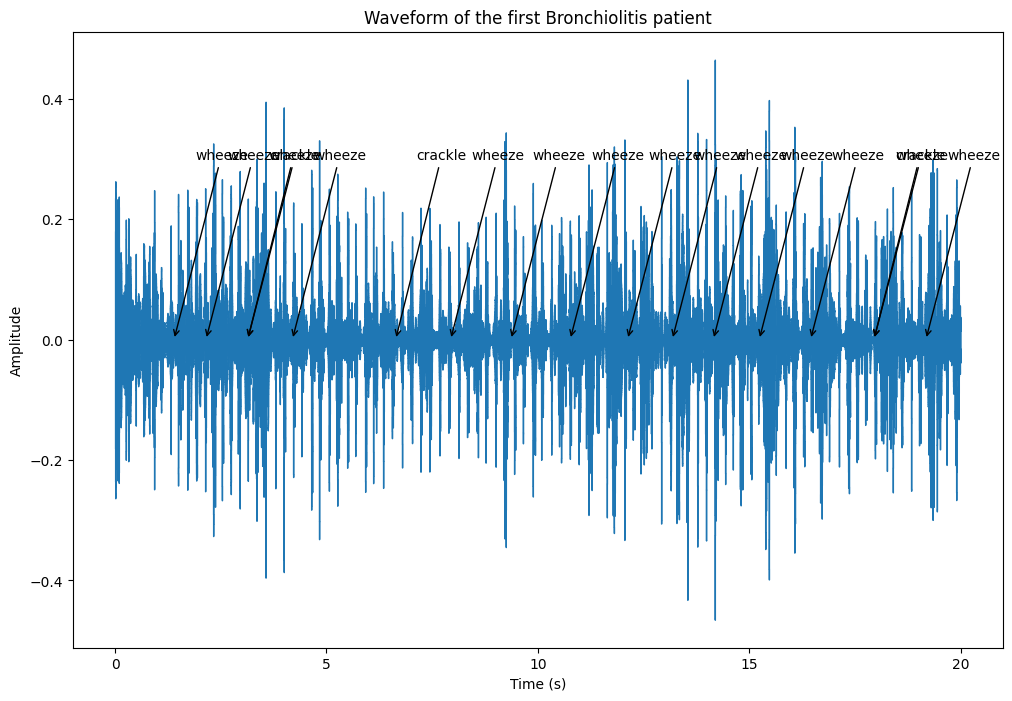

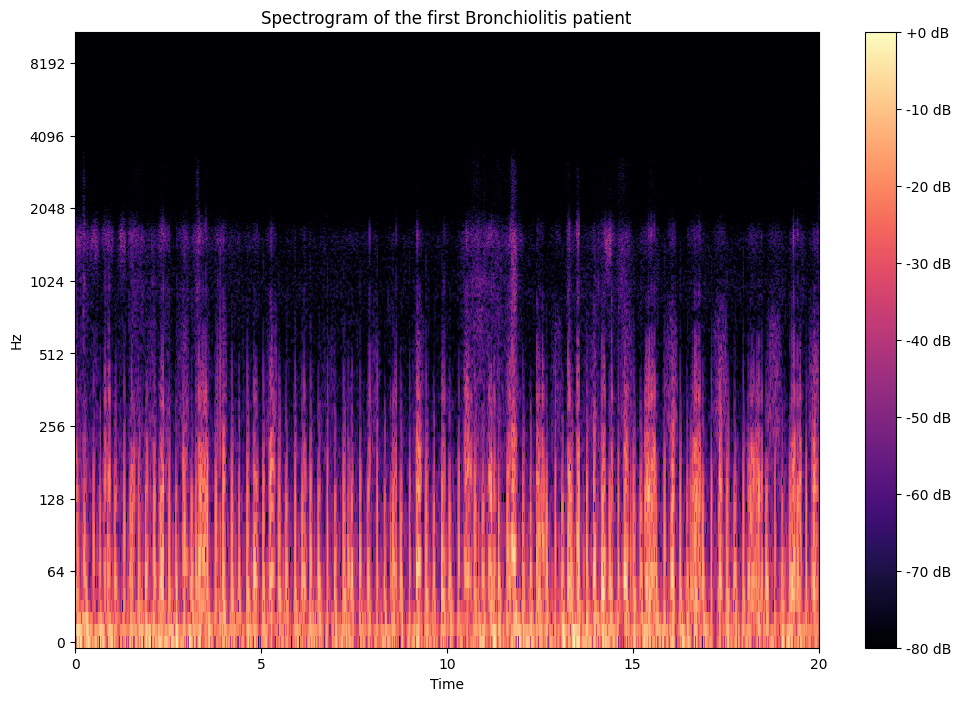

(array([-0.12161022, -0.18025038, -0.16308574, ...,  0.01879526,
         0.01824916,  0.02011252], dtype=float32),
 22050)

In [84]:
wav_filename = generate_plot(merged_df, "Bronchiolitis")
Audio(Path.cwd() / "data" / dataset_selected / wav_filename)
generate_spectrogram(wav_filename, "Bronchiolitis")

# Pneumonia

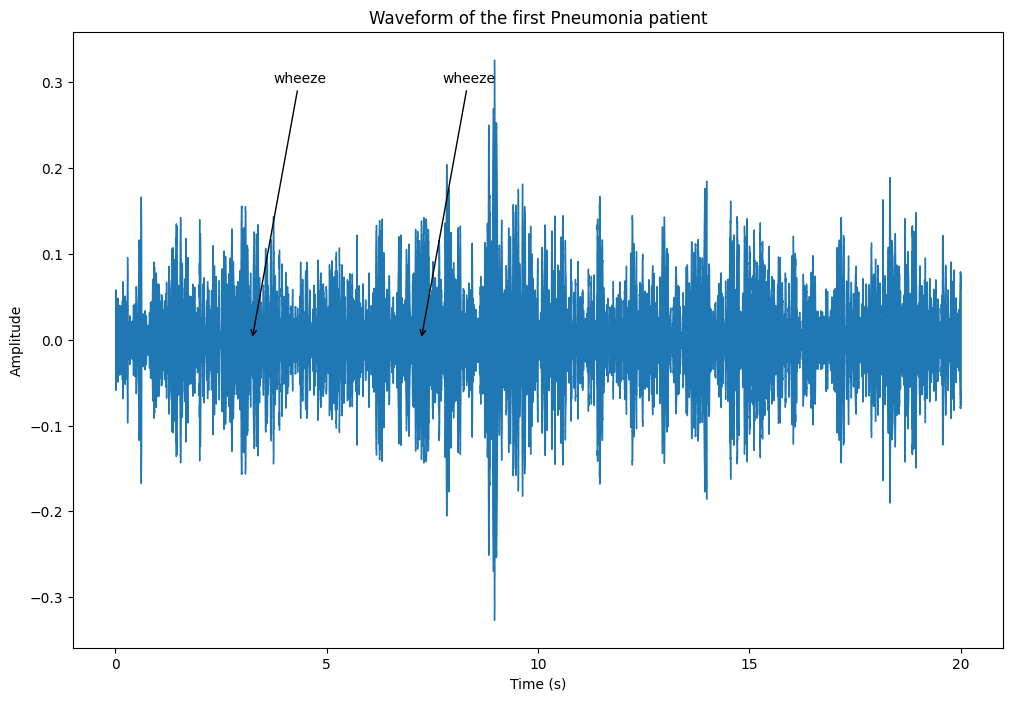

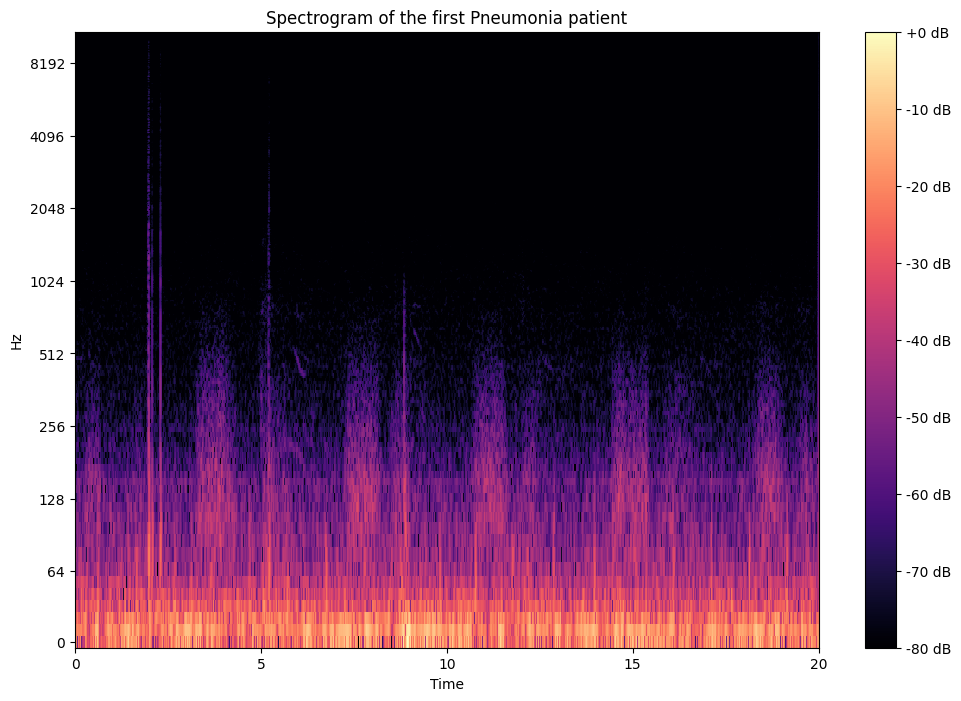

(array([-0.02921091, -0.04258309, -0.03838915, ..., -0.07247789,
        -0.06979419, -0.07583347], dtype=float32),
 22050)

In [85]:
wav_filename = generate_plot(merged_df, "Pneumonia")
Audio(Path.cwd() / "data" / "selected_files" / wav_filename)
generate_spectrogram(wav_filename, "Pneumonia")

# Feature extraction

In [86]:
# Data augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data=data, sample_rate=sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data=data)
    res2 = extract_features(data=noise_data, sample_rate=sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    return result

In [ ]:
# get features for all the selected files
X = []
y = []
print(merged_df)
for filename in selected_filenames:
    if filename.endswith("wav"):
        features = get_features(Path.cwd() / "data" / dataset_selected / filename)
        # we made 3 data augmentation, so we have 3 sets of features for each file
        for feature in features:
            patient_number = filename.split('_')[0].split('.')[0]
            # we remove the patient 101 because it isnt in merged_df
            if patient_number == '101':
                continue
            X.append(feature)
            print(patient_number)
            label = merged_df[merged_df['patient_number'] == int(patient_number)]['diagnosis'].values[0]
            y.append(label)

X = np.array(X)
y = np.array(y)


     patient_number    age  sex  adult_bmi  child_weight  child_height  \
0               102   0.75    F        NaN           9.8          73.0   
1               103  70.00    F      33.00           NaN           NaN   
2               104  70.00    F      28.47           NaN           NaN   
3               105   7.00    F        NaN          32.0         135.0   
4               106  73.00    F      21.00           NaN           NaN   
..              ...    ...  ...        ...           ...           ...   
120             222  60.00    M        NaN           NaN           NaN   
121             223    NaN  NaN        NaN           NaN           NaN   
122             224  10.00    F        NaN          32.3         143.0   
123             225   0.83    M        NaN           7.8          74.0   
124             226   4.00    M        NaN          16.7         103.0   

     diagnosis  
0      Healthy  
1       Asthma  
2         COPD  
3         URTI  
4         COPD  
..       

c:\Users\alexa\miniconda3\envs\son\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


104
104
104
104
104
104
104
104
104
104
104
104
105
105
106
106
106
106
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
107
108
108
109
109
109
109
109
109
109
109
109
109
109
109
110
110
110
110
110
110
110
110
110
110
111
111
111
111
112
112
112
112
112
112
112
112
112
112
113
113
113
113
113
113
113
113
113
113
113
113
114
114
114
114
114
114
114
114
114
114
115
115
116
116
116
116
117
117
117
117
118
118
118
118
118
118
118
118
118
118
118
118
119
119
120
120
120
120
120
120
120
120
120
120
121
121
121
121
122
122
122
122
122
122
122
122
122
122
122
122
122
122
122
122
122
122
123
123
124
124
124
124
124
124
124
124
124
124
124
124
125
125
126
126
127
127
128
128
129
129
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130


In [ ]:
Features = pd.DataFrame(X)
Features['label'] = y
Features.to_csv('features.csv', index=False)
print(Features)

(1836, 162) (1836,)
             0         1         2         3         4         5         6  \
0     0.001402  0.843658  0.884091  0.913450  0.914516  0.869469  0.792956   
1     0.008572  0.890285  0.916002  0.942086  0.946120  0.934040  0.838094   
2     0.001072  0.779321  0.808086  0.844489  0.870172  0.890875  0.849569   
3     0.024572  0.901519  0.919980  0.923100  0.953143  0.960163  0.842506   
4     0.005769  0.715590  0.773748  0.774199  0.743004  0.704249  0.679561   
...        ...       ...       ...       ...       ...       ...       ...   
1831  0.045758  0.900674  0.889709  0.899753  0.918307  0.927882  0.901796   
1832  0.002012  0.846896  0.848375  0.867346  0.890213  0.872840  0.854448   
1833  0.016330  0.891909  0.907904  0.931855  0.943309  0.938003  0.874422   
1834  0.001985  0.818253  0.843866  0.849200  0.868042  0.885364  0.901702   
1835  0.018953  0.898080  0.913023  0.919707  0.939626  0.947604  0.872358   

             7         8         9  ...    

# Random forest

In [100]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



def objective(trial):
    # hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    score = classification_report(y_test, y_pred, output_dict=True)['accuracy']

    return score

In [103]:
# Create a study
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy

# Optimize the objective function
study.optimize(objective, n_trials=100)

# best parameters
print("Best trial:")
trial = study.best_trial
print("Value: {:.4f}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-03 10:11:01,871] A new study created in memory with name: no-name-f7019d8b-187a-4eab-8814-530f582deb82
c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Best trial:
Value: 0.8750
Params: 
    n_estimators: 231
    max_depth: 21
    min_samples_split: 5
    min_samples_leaf: 3


In [105]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Fit the final model
final_model.fit(X_train, y_train)

# Evaluate the final model
final_y_pred = final_model.predict(X_test)
print(classification_report(y_test, final_y_pred))

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.17      0.29         6
 Bronchiolitis       0.00      0.00      0.00         5
          COPD       0.89      0.99      0.94       312
       Healthy       0.57      0.53      0.55        15
          LRTI       0.00      0.00      0.00         1
     Pneumonia       1.00      0.16      0.27        19
          URTI       0.00      0.00      0.00        10

      accuracy                           0.88       368
     macro avg       0.49      0.26      0.29       368
  weighted avg       0.84      0.88      0.84       368



c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\miniconda3\envs\son\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# AST model

## Create dataset

In [209]:
import torch
from transformers import ASTFeatureExtractor
from datasets import Dataset, Audio, ClassLabel, Features

class_labels = ClassLabel(names=["Healthy", "Asthma", "COPD", "URTI", "LRTI", "Bronchiectasis", "Bronchiolitis", "Pneumonia"])

features = Features({
    "audio": Audio(),
    "labels": class_labels
})

# we create a dataframe associating each .wav file to its label
data = []
for filename in selected_filenames:
    if filename.endswith("wav"):
        patient_number = filename.split('_')[0].split('.')[0]
        if patient_number == '101':
            continue
        label = merged_df[merged_df['patient_number'] == int(patient_number)]['diagnosis'].values[0]
        data.append({"audio": Path.cwd() / "data" / dataset_selected / filename, "labels": label})



dataset = Dataset.from_dict({
    "audio": [str(row["audio"]) for row in data],
    "labels": [row["labels"] for row in data]
}, features=features)

## Feature extraction

We create spectrogram again but using the model feature extractor

In [210]:
# we define which pretrained model we want to use and instantiate a feature extractor
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)
# we save model input name and sampling rate for later use
model_input_name = feature_extractor.model_input_names[0]  # key -> 'input_values'
SAMPLING_RATE = feature_extractor.sampling_rate

# Data augmentation

In [211]:
from audiomentations import Compose, AddGaussianSNR, GainTransition, Gain, ClippingDistortion, TimeStretch, PitchShift

audio_augmentations = Compose([
    AddGaussianSNR(min_snr_db=10, max_snr_db=20),
    Gain(min_gain_db=-6, max_gain_db=6),
    GainTransition(min_gain_db=-6, max_gain_db=6, min_duration=0.01, max_duration=0.3, duration_unit="fraction"),
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=30, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2),
    PitchShift(min_semitones=-4, max_semitones=4),
], p=0.8, shuffle=True) # p is the probability of applying the augmentations to each audio clip and the shuffle random the order of application

We create a preprocessing function to convert the data to inputs understandable by the model

In [212]:
def preprocess_audio(batch):
    wavs = [audio["array"] for audio in batch["input_values"]]
    # inputs are spectrograms as torch.tensors now
    inputs = feature_extractor(wavs, sampling_rate=SAMPLING_RATE, return_tensors="pt")
    
    output_batch = {model_input_name: inputs.get(model_input_name), "labels": list(batch["labels"])}
    return output_batch

def preprocess_audio_with_transforms(batch):
    # we apply augmentations on each waveform
    wavs = [audio_augmentations(audio["array"], sample_rate=SAMPLING_RATE) for audio in batch["input_values"]]
    inputs = feature_extractor(wavs, sampling_rate=SAMPLING_RATE, return_tensors="pt")
    
    output_batch = {model_input_name: inputs.get(model_input_name), "labels": list(batch["labels"])}
    return output_batch

In [213]:
# Filter out classes with fewer than 2 samples
label_counts = pd.Series(dataset["labels"]).value_counts()
valid_labels = label_counts[label_counts >= 2].index.tolist()
filtered_dataset = dataset.filter(lambda example: example["labels"] in valid_labels)

# split the dataset
splited_dataset = filtered_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="labels")  # stratify_by_column ensures correct representation of labels in the train and test sets
print(splited_dataset)

# with augmentations on the training set
splited_dataset["train"].set_transform(preprocess_audio_with_transforms, output_all_columns=False)
# w/o augmentations on the test set
splited_dataset["test"].set_transform(preprocess_audio, output_all_columns=False)

splited_dataset = splited_dataset.rename_column("audio", "input_values") 
splited_dataset = splited_dataset.cast_column("input_values", Audio(sampling_rate=feature_extractor.sampling_rate))

Filter: 100%|██████████| 918/918 [00:05<00:00, 168.86 examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'labels'],
        num_rows: 733
    })
    test: Dataset({
        features: ['audio', 'labels'],
        num_rows: 184
    })
})


We determine normalization values ( mean and std ) to adapt to our custom dataset

In [214]:
# calculate values for normalization
feature_extractor.do_normalize = False  # we set normalization to False in order to calculate the mean + std of the dataset
mean = []
std = []

# we use the transformation w/o augmentation on the training dataset to calculate the mean + std
# splited_dataset["train"].set_transform(preprocess_audio, output_all_columns=False)
for i, (input_values, labels) in enumerate(splited_dataset["train"]):
    cur_mean = torch.mean(splited_dataset["train"][i][input_values])
    cur_std = torch.std(splited_dataset["train"][i][input_values])
    mean.append(cur_mean)
    std.append(cur_std)
feature_extractor.mean = np.mean(mean)
feature_extractor.std = np.mean(std)
feature_extractor.do_normalize = True

# Init AST

In [222]:
# Extract final labels
features_dict = splited_dataset["train"].features
label_list = features_dict['labels'].names

num_labels = len(label_list)

label2id = {
    "Healthy": 0,
    "Asthma": 1,
    "COPD": 2,
    "URTI": 3,
    "LRTI": 4,
    "Bronchiectasis": 5,
    "Bronchiolitis": 6,
    "Pneumonia": 7
  }

In [223]:
from transformers import ASTConfig, ASTForAudioClassification

# Load configuration from the pretrained model
config = ASTConfig.from_pretrained(pretrained_model)
# Update configuration with the number of labels in our dataset
config.num_labels = num_labels
config.label2id = label2id
config.id2label = {v: k for k, v in label2id.items()}
# Initialize the model with the updated configuration
model = ASTForAudioClassification.from_pretrained(pretrained_model, config=config, ignore_mismatched_sizes=True)
model.init_weights()

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [228]:
from transformers import TrainingArguments

# Configure training run with TrainingArguments class
training_args = TrainingArguments(
    output_dir="./runs/ast_classifier",
    logging_dir="./logs/ast_classifier",
    report_to="tensorboard",
    learning_rate=5e-5,  # Learning rate
    push_to_hub=False,
    num_train_epochs=10,  # Number of epochs
    per_device_train_batch_size=8,  # Batch size per device
    eval_strategy="epoch",  # Evaluation strategy
    save_strategy="epoch",
    eval_steps=1,
    save_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="steps",
    logging_steps=20,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`